In [1]:
# Core Python and scientific stack
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob
from PIL import Image
from IPython.display import clear_output
clear_output(wait=True)

# Torch
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision utilities (e.g., transforms, datasets)
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Classification

Datset from Kaggle on [Brain Cancer MRI](https://www.kaggle.com/datasets/orvile/brain-cancer-mri-dataset/code). Add it to the input data of your notebook by clicking "Add Input" in the left of the screen and look for the "Brain Cancer - MRI Dataset". 

For researching purposes we will train a custom CNN build block by block and a pre-trained CNN by loading its weights and just changing the last layer.

In [3]:
# Classification-specific evaluation tools
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Importing dataset
data_dir = "/kaggle/input/brain-cancer-mri-dataset/Brain_Cancer raw MRI data/Brain_Cancer"
print(os.listdir(data_dir))

['brain_tumor', 'brain_glioma', 'brain_menin']


Classes: ['brain_glioma', 'brain_menin', 'brain_tumor']
Total number of images: 6056


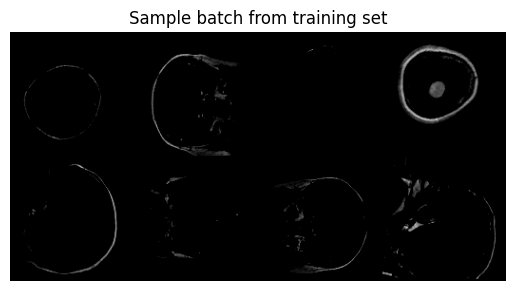

In [4]:
# Preprocessing: resize images, convert to tensor, normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # If RGB images: adjust to [0.5, 0.5, 0.5]
])

# Load dataset assuming folder structure by class
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Dataset split: 70% train, 15% val, 15% test
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size  # Remaining samples

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)   # Used for hyperparameter tuning
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Final evaluation only

print("Classes:", dataset.classes)
print("Total number of images:", len(dataset))

# Visual check: sample batch from training set
images, labels = next(iter(train_loader))
img_grid = torchvision.utils.make_grid(images[:8], nrow=4)
np_img = img_grid.numpy().transpose((1, 2, 0))

plt.imshow(np_img)
plt.title("Sample batch from training set")
plt.axis('off')
plt.show()

## Custom CNN
The model used here is a simple convolutional neural network designed for multi-class classification on grayscale brain MRI images.

### Architecture:
1. **Conv2D Layer**
   - Input channels: 1 (grayscale images)
   - Output channels: 16
   - Kernel size: \(3 \times 3\)
   - Padding: 1 (preserves spatial size)
   - Activation: ReLU
   - MaxPooling: \(2 \times 2\) (reduces spatial resolution by half)
   - Output shape: \([B, 16, 64, 64]\)

2. **Conv2D Layer**
   - Input channels: 16
   - Output channels: 32
   - Kernel size: \(3 \times 3\)
   - Padding: 1
   - Activation: ReLU
   - MaxPooling: \(2 \times 2\)
   - Output shape: \([B, 32, 32, 32]\)

3. **Flatten Layer**
   - Flattens the output tensor into a vector of size \(32 \times 32 \times 32 = 32,768\)

4. **Fully Connected Layer (FC1)**
   - Input size: 32,768
   - Output size: 128
   - Activation: ReLU

5. **Fully Connected Layer (FC2)**
   - Input size: 128
   - Output size: 3 (number of classes)
   - Output: raw logits (used with `CrossEntropyLoss`)

In [5]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 1 input channel as it is in grayscale
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128) # After two poolings: 128 → 64 → 32
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, 32, 32]
        x = x.view(-1, 32 * 32 * 32)          # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()                    # Multiclass classification
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer for faster convergence, LR can be tuned

In [7]:
num_epochs = 5

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation phase (no gradients)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}, Training loss: {avg_train_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%")


Epoch 1, Training loss: 0.7494, Validation accuracy: 72.80%
Epoch 2, Training loss: 0.5322, Validation accuracy: 74.78%
Epoch 3, Training loss: 0.4248, Validation accuracy: 75.99%
Epoch 4, Training loss: 0.3204, Validation accuracy: 78.30%
Epoch 5, Training loss: 0.2181, Validation accuracy: 78.74%


Test accuracy: 80.64%


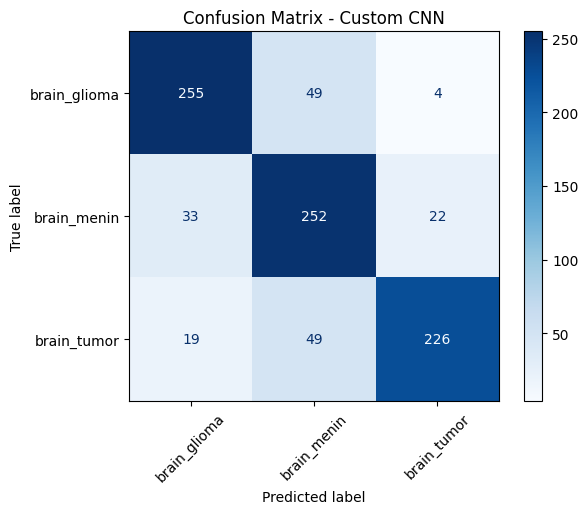

              precision    recall  f1-score   support

brain_glioma       0.83      0.83      0.83       308
 brain_menin       0.72      0.82      0.77       307
 brain_tumor       0.90      0.77      0.83       294

    accuracy                           0.81       909
   macro avg       0.82      0.81      0.81       909
weighted avg       0.81      0.81      0.81       909



In [8]:
# Evaluation of the model
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'Test accuracy: {test_accuracy:.2f}%')

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Custom CNN")
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=dataset.classes))

## Pretrained CNN
The `ResNet18` is one of the **smallest versions of ResNet**, with 18 layers. Is much faster to train and fine-tune, especially on small datasets. There is a lower risk of overfitting on small medical imaging datsets due to fewer parameters. Other ResNets might be bigger in terms of number of parameters and might be used for larger datasets or more complex tasks. 

⚡️ Rule of Thumb:
* Small dataset (few hundred to few thousand images): ResNet18 or ResNet34.
* Medium dataset (tens of thousands): ResNet34 or ResNet50.
* Large dataset (hundreds of thousands or more): ResNet50, ResNet101.

🟢 Alternatives to ResNet worth testing:
* EfficientNet-B0 (very compact, high performance per parameter).
* DenseNet121 (good at feature reuse, smaller footprint).
* MobileNetV2 (lightweight, good for deployment scenarios).

⚠️ **Issue with kaggle**: Kaggle environment is not able to access directly external URLs as it blocks outbound internet connections by default for security reasons, so it cannot download the pretrained weights directly from PyTorch servers. Here you would have two options:
1. Download the weights locally onyour machine from [here for ResNet18](https://download.pytorch.org/models/resnet18-f37072fd.pth) and upload the weights file to Kaggle via "Add Data" and load the model manually as:
 ```
 resnet = models.resnet18(weights=None)
 state_dict = torch.load("/kaggle/input/your-uploaded-folder/resnet18-f37072fd.pth", map_location=device)
 resnet.load_state_dict(state_dict)
 ```
2. Testing just the architecture of the network without using the pretrained weights:
 ```
resnet = models.resnet18(weights=None)
 ```

As this is just for teaching purposes and see how to use a pre-trained network, we will stick to Option 2. 

In [9]:
# import torch
# from torchvision import models

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# resnet = models.resnet18(weights=None)  # O "weights='IMAGENET1K_V1'" si quieres usar pesos preentrenados
# state_dict = torch.load("/kaggle/input/your-uploaded-folder/pytorch/default/1/resnet18-f37072fd.pth", map_location=device)
# resnet.load_state_dict(state_dict)
# resnet.to(device)
# resnet.eval()

In [10]:
import torch
from torchvision import models
# Load pretrained ResNet18 model
resnet = models.resnet18(weights=None)

# Replace the first convolutional layer to accept 1 input channel (grayscale)
resnet.conv1 = nn.Conv2d(
    in_channels=1,       # Change from 3 to 1
    out_channels=64, 
    kernel_size=7, 
    stride=2, 
    padding=3, 
    bias=False
)

# Optional: freeze pretrained layers (except the final classifier)
for param in resnet.parameters():
    param.requires_grad = False

# Replace the final fully connected layer for 3 classes
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 3)

resnet = resnet.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)  # Only optimizing the final layer

num_epochs = 5

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    resnet.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}, Training loss: {avg_train_loss:.4f}, Validation accuracy: {val_accuracy:.2f}%")

Epoch 1, Training loss: 1.0056, Validation accuracy: 58.04%
Epoch 2, Training loss: 0.8818, Validation accuracy: 63.00%
Epoch 3, Training loss: 0.8231, Validation accuracy: 64.21%
Epoch 4, Training loss: 0.8032, Validation accuracy: 65.64%
Epoch 5, Training loss: 0.7770, Validation accuracy: 64.65%


Test accuracy (ResNet18): 67.77%


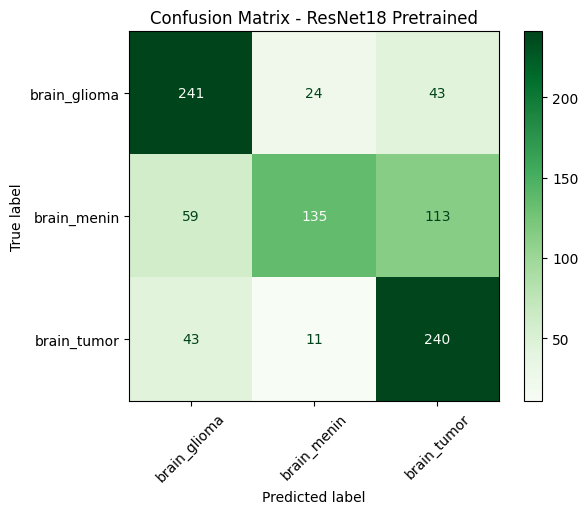

              precision    recall  f1-score   support

brain_glioma       0.70      0.78      0.74       308
 brain_menin       0.79      0.44      0.57       307
 brain_tumor       0.61      0.82      0.70       294

    accuracy                           0.68       909
   macro avg       0.70      0.68      0.67       909
weighted avg       0.70      0.68      0.67       909



In [12]:
# Evaluation
resnet.eval()
all_preds_resnet = []
all_labels_resnet = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds_resnet.extend(predicted.cpu().numpy())
        all_labels_resnet.extend(labels.cpu().numpy())

# Test accuracy
test_correct = sum(p == l for p, l in zip(all_preds_resnet, all_labels_resnet))
test_total = len(all_labels_resnet)
test_accuracy = 100 * test_correct / test_total
print(f'Test accuracy (ResNet18): {test_accuracy:.2f}%')

# Confusion matrix
cm_resnet = confusion_matrix(all_labels_resnet, all_preds_resnet)
disp_resnet = ConfusionMatrixDisplay(confusion_matrix=cm_resnet, display_labels=dataset.classes)
disp_resnet.plot(cmap='Greens', xticks_rotation=45)
plt.title("Confusion Matrix - ResNet18 Pretrained")
plt.show()

# Classification report
print(classification_report(all_labels_resnet, all_preds_resnet, target_names=dataset.classes))


# Object Detetion
In this section, we will use **YOLOv8 (You Only Look Once)** for object detection on medical images (brain tumor detection).  
YOLO is one of the most popular and efficient architectures for object detection tasks because of its speed and ease of use.

### ⚠️ Dataset Preparation (The Real Challenge!)

One of the **most complex and critical steps** when using YOLO (any version, including YOLOv8) is not the model itself, but the **preparation of the dataset and the correct formatting of the labels**.

YOLO requires:
- **Images folder**: containing your `.jpg` or `.png` files.
- **Labels folder**: with `.txt` files for each image, containing annotations in the format:
  ```
  class x_center y_center width height
  ```
  where all coordinates are **normalized between 0 and 1** relative to the image dimensions.

The dataset structure typically looks like this:
```
dataset/
├── train/
│   ├── images/
│   └── labels/
├── valid/
│   ├── images/
│   └── labels/
├── data.yaml
```

The `data.yaml` configuration file tells YOLO where to find the training and validation sets and defines the class names.

Example `data.yaml`:
```yaml
train: /path/to/train/images
val: /path/to/valid/images
names:
  0: tumor
```

Carefully preparing this format is **essential** for proper training and evaluation.  
Incorrect label formatting or path definitions are common sources of errors when working with YOLO-based models.

---

In this notebook, we will work directly with a **pre-prepared dataset** in YOLO format to focus on training, inference, and evaluation.

In [13]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 982.4/982.4 kB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [14]:
# YOLO object detection library
from ultralytics import YOLO

# Load YOLOv8 nano (fastest variant)
model = YOLO('yolov8n.pt')  # 'n' = nano, prioritize speed

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 163MB/s]


In [15]:
import yaml

# Define input YAML path (from your Kaggle dataset)
input_yaml_path = '/kaggle/input/brain-tumor-object-detection-yolo/Brain Tumor - Object Detection - YOLO/data.yaml'

# Define correct absolute paths to your train and val images folders
train_images_path = '/kaggle/input/brain-tumor-object-detection-yolo/Brain Tumor - Object Detection - YOLO/train/images'
val_images_path = '/kaggle/input/brain-tumor-object-detection-yolo/Brain Tumor - Object Detection - YOLO/valid/images'

# Load the original YAML
with open(input_yaml_path, 'r') as file:
    data_yaml = yaml.safe_load(file)

# Modify the paths
data_yaml['train'] = train_images_path
data_yaml['val'] = val_images_path

# Write the updated YAML to /kaggle/working/
output_yaml_path = '/kaggle/working/data.yaml'
with open(output_yaml_path, 'w') as file:
    yaml.dump(data_yaml, file)

print(f"✅ YAML updated and saved to: {output_yaml_path}")
print("YAML content:")
print(data_yaml)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/brain-tumor-object-detection-yolo/Brain Tumor - Object Detection - YOLO/data.yaml'

In [ ]:
model.train(
    data=input_yaml_path, 
    epochs=2,             # You can increase this later for better performance
    imgsz=416,             # Image size (must match your dataset prep)
    batch=8,               # Adjust based on GPU memory
    conf=0.3,              # Confidence threshold (optional during training)
    device='cuda' if torch.cuda.is_available() else 'cpu',
    verbose=False
)

In [ ]:
# Load the trained model
model_path = 'runs/detect/train/weights/best.pt'  # Adjust path if different
model = YOLO(model_path)

# Define the directory with validation images
source_dir = '/kaggle/input/brain-tumor-object-detection-yolo/Brain Tumor - Object Detection - YOLO/valid/images/'

# Run inference WITHOUT saving the images
results = model.predict(
    source=source_dir,
    save=False,               # Don't save to disk
    conf=0.3,                 # Confidence threshold
    iou=0.5,                  # IoU threshold
    device='cuda' if torch.cuda.is_available() else 'cpu',
    imgsz=416,
    verbose=False
)

# Show the first few predictions inline
plt.figure(figsize=(15, 10))
for i, result in enumerate(results[:4]):   # Show first 4 images
    img = Image.fromarray(result.plot()[..., ::-1])  # result.plot() returns BGR numpy array
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(f"Prediction {i+1}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Segmentation

Dataset from the Cell Tracking Challenge, focused on cell segmentation. This dataset contains **phase contrast microscopy images** of _stem cells_ growing. 

You can add this dataset to your notebook by clicking "Add Input" on the left side of the screen, and selecting **PhC-C2DL-PSC - Cell Tracking Challenge**.

Each sample includes:

* **Input image**: a grayscale microscopy image of cells.
* **Segmentation mask**

For researching purposes we will train a custom UNet build block by block and a pre-trained CNN from MONAI. 


- **Install MONAI**: MONAI is a library for medical image processing and pre-trained neural networks. We use a pre-trained **UNet model** for image segmentation.

- **Data Preparation**:
  - Load images and segmentation masks from the corresponding folders.
  - Filter matching image and mask paths to ensure each image has its associated mask.

- **Dataset and DataLoader**:
  - Create a DataLoader to load images and masks in batches.
  - Check the dimensions of a batch of images and masks to ensure they are loaded correctly.


In [ ]:
!pip install -q "monai[all]"

In [ ]:
# MONAI (for pretrained model)
from monai.transforms import Compose, Resize, ToTensor
from monai.networks.nets import UNet

# Evaluation (later)
from sklearn.metrics import jaccard_score

In [ ]:
image_dir = "/kaggle/input/phc-c2dl-psc/PhC-C2DL-PSC-CellTrackingChallenge/train/01"
mask_dir  = "/kaggle/input/phc-c2dl-psc/PhC-C2DL-PSC-CellTrackingChallenge/train/01_ST/SEG"

image_paths = sorted(glob(os.path.join(image_dir, '*.tif')))
mask_paths  = sorted(glob(os.path.join(mask_dir, '*.tif')))

# Build a lookup of image name endings → full path
image_dict = {os.path.splitext(os.path.basename(p))[0][-3:]: p for p in image_paths}
mask_dict  = {os.path.splitext(os.path.basename(p))[0][-3:]: p for p in mask_paths}

# Intersect keys to find matching image/mask pairs
matching_keys = sorted(set(image_dict.keys()) & set(mask_dict.keys()))

filtered_image_paths = [image_dict[k] for k in matching_keys]
filtered_mask_paths  = [mask_dict[k] for k in matching_keys]

print(f"✅ Found {len(filtered_image_paths)} image-mask pairs.")

In [ ]:
class CellSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, image_size=(128, 128)):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),                  # Converts to [0, 1] float tensor
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(self.image_paths[idx]).convert('L')  # Force grayscale ('L')
        mask = Image.open(self.mask_paths[idx]).convert('L')

        # Apply transforms
        image = self.transform(image)
        mask = self.transform(mask)
        mask = (mask > 0).float()  # Convert mask to binary (0 or 1)

        return image, mask

In [ ]:
# Assuming image_paths and mask_paths are already defined and sorted correctly
dataset = CellSegmentationDataset(image_paths, mask_paths)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Check one batch
images, masks = next(iter(dataloader))
print(images.shape)  # Should be [B, 1, H, W]
print(masks.shape)   # Should be [B, 1, H, W]

## Simple UNet

In [ ]:
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(SimpleUNet, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

        self.out_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))<
        return torch.sigmoid(self.out_conv(d1))

## Simple U-Net

This is a simplified version of the U-Net architecture, primarily used for image segmentation tasks. It takes grayscale input images and outputs a pixel-wise segmentation mask.

### Architecture Overview:

#### Encoder:
- **Block 1**:  
  - `Conv2D`: (1 → 32 channels), Kernel: (3×3), ReLU  
  - `Conv2D`: (32 → 32 channels), Kernel: (3×3), ReLU  
  - `MaxPool2D`: (2×2)

- **Block 2**:  
  - `Conv2D`: (32 → 64 channels), Kernel: (3×3), ReLU  
  - `Conv2D`: (64 → 64 channels), Kernel: (3×3), ReLU  
  - `MaxPool2D`: (2×2)

#### Bottleneck:
- **Block 3**:  
  - `Conv2D`: (64 → 128 channels), Kernel: (3×3), ReLU  
  - `Conv2D`: (128 → 128 channels), Kernel: (3×3), ReLU

#### Decoder:
- **Block 2**:  
  - `ConvTranspose2D`: (128 → 64 channels), Kernel: (2×2), Stride: 2  
  - `Conv2D`: (128 → 64 channels), Kernel: (3×3), ReLU  
  - `Conv2D`: (64 → 64 channels), Kernel: (3×3), ReLU

- **Block 1**:  
  - `ConvTranspose2D`: (64 → 32 channels), Kernel: (2×2), Stride: 2  
  - `Conv2D`: (64 → 32 channels), Kernel: (3×3), ReLU  
  - `Conv2D`: (32 → 32 channels), Kernel: (3×3), ReLU

#### Output:
- `Conv2D`: (32 → 1 channel), Kernel: (1×1)  
- `Sigmoid` activation: Produces output in [0, 1] for binary segmentation



This **Simple U-Net** follows an encoder-decoder structure with skip connections. U-Net is a convolutional neural network architecture specifically designed for image segmentation tasks. It uses convolutional layers not only to extract spatial features in the encoder by progressively downsampling the input, but also to reconstruct fine details in the decoder by upsampling the features to produce a segmentation mask. Skip connections help preserve spatial information by directly linking encoder and decoder layers at the same resolution level.



In [ ]:
model = SimpleUNet(in_channels=1, out_channels=1).to(device)

# Loss function: Binary Cross Entropy (BCE)
criterion = nn.BCELoss()  # You can replace with DiceLoss or BCE+Dice if you want

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 5  # Adjust if needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        preds = model(images)
        loss = criterion(preds, masks)

        # Backward pass and optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Avg Training Loss: {avg_loss:.4f}")

### Model Training

This section trains the Simple U-Net model for a binary segmentation task.

- **Model Initialization**:  
  The `SimpleUNet` is instantiated with 1 input and 1 output channel, suitable for grayscale images and binary masks.

- **Loss Function**:  
  `BCELoss` (Binary Cross Entropy) is used to measure the error between predicted and ground truth masks.  
  > Optionally, you can replace it with `DiceLoss` or a combination of `BCE + Dice` for better performance on imbalanced datasets.

- **Optimizer**:  
  `Adam` optimizer is used with a learning rate of `0.001`.

- **Training Loop**:
  - For each epoch:
    - Set model to training mode.
    - Loop over the batches of images and masks:
      - Perform forward pass to obtain predictions.
      - Compute loss.
      - Backpropagate and update weights.
    - Print the average training loss for the epoch.

- The model was trained for **5 epochs**.

The training loss decreased consistently over time, indicating that the model was learning and improving its predictions. This steady drop in loss suggests that the model is converging well and learning to produce accurate segmentation masks.

In [ ]:
model.eval()
with torch.no_grad():
    images, masks = next(iter(dataloader))  # Get one batch
    images = images.to(device)
    preds = model(images).cpu()
    preds = (preds > 0.5).float()  # Binarize predictions

# Show first 4 samples
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(4, 3, i * 3 + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title("Input")
    plt.axis('off')

    plt.subplot(4, 3, i * 3 + 2)
    plt.imshow(masks[i].cpu().squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(4, 3, i * 3 + 3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def dice_score(pred, target, epsilon=1e-6):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

# Example for the first sample
dice = dice_score(preds[0], masks[0])
print(f"Dice score (sample 0): {dice:.4f}")

### Model Evaluation

- **Evaluation Mode**: The model is set to `.eval()` and gradients are disabled using `torch.no_grad()` for inference.
- **Batch Prediction**: A batch of input images is passed through the model to generate segmentation masks.
- **Binarization**: Predictions are thresholded at 0.5 to obtain binary masks.
- **Metric – Dice Score**:
  - Measures overlap between prediction and ground truth.
  - Values range from 0 (no overlap) to 1 (perfect match).
  - Score for one sample: **0.8935**, indicating high segmentation accuracy.


## MONAI UNet

In [ ]:
# MONAI UNet setup
model_monai = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,  # Binary segmentation
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

# Loss and optimizer (same as SimpleUNet for fair comparison)
criterion_monai = nn.BCEWithLogitsLoss()
optimizer_monai = optim.Adam(model_monai.parameters(), lr=0.001)

### Image Segmentation with MONAI's UNet

In this section, we will use a predefined **UNet** model from the [**MONAI**](https://monai.io/) framework, which is specifically designed for deep learning in medical imaging. MONAI provides a robust and optimized implementation of UNet that is ready to use for segmentation tasks. 


Here's a breakdown of the setup:
- **Input and Output**:
  - Input: 1-channel (grayscale) images.
  - Output: 1-channel binary mask (segmentation output).

- **Architecture Details**:
  - Classic encoder-decoder UNet structure.
  - Channels per layer: `(16, 32, 64, 128, 256)`.
  - Strides: `(2, 2, 2, 2)` for downsampling.
  - `num_res_units=2`: Each level has two residual units, improving learning capacity.

- **Loss Function**:
  - `BCEWithLogitsLoss`: Combines a sigmoid layer and binary cross-entropy in a single, stable function.
  - Suitable for binary segmentation tasks.

- **Optimizer**:
  - `Adam` with learning rate `0.001`.
  - Chosen for its adaptive behavior and fast convergence.

- **Why MONAI?**
  - MONAI provides robust, tested, and optimized models for medical imaging.
  - Saves time and ensures best practices for network design.

> 💡 Keeping the loss and optimizer identical to the SimpleUNet ensures a **fair comparison** between models.



In [ ]:
# Training
num_epochs = 5  # Adjust as needed

for epoch in range(num_epochs):
    model_monai.train()
    running_loss = 0.0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        preds = model_monai(images)
        loss = criterion_monai(preds, masks)

        optimizer_monai.zero_grad()
        loss.backward()
        optimizer_monai.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)
    print(f"MONAI UNet - Epoch [{epoch+1}/{num_epochs}] - Avg Training Loss: {avg_loss:.4f}")

### Training Loop: Same Structure, Different Models

We use the **same training loop** structure for both the simple UNet and the MONAI UNet to ensure a **fair comparison**. Only the components related to each model are different.

- 🔁 **Loop logic**:
  - Identical for both models: forward pass → loss → backward pass → optimizer step → loss logging.

- ⚙️ **What changes**:
  - `model` → `model_monai`
  - `criterion` → `criterion_monai`
  - `optimizer` → `optimizer_monai`

- **Why?**
  - Keeping the training pipeline consistent helps isolate the **performance differences** to the model architecture itself.


In [ ]:
# Evaluation
model_monai.eval()
with torch.no_grad():
    images, masks = next(iter(dataloader))
    images = images.to(device)
    preds = torch.sigmoid(model_monai(images)).cpu()  # 👈 Sigmoid here!
    preds = (preds > 0.5).float()                     # Binarize predictions

# Plot predictions
plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(4, 3, i * 3 + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap='gray')
    plt.title("Input")
    plt.axis('off')

    plt.subplot(4, 3, i * 3 + 2)
    plt.imshow(masks[i].cpu().squeeze(), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(4, 3, i * 3 + 3)
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.title("MONAI UNet Prediction")
    plt.axis('off')

plt.tight_layout()
plt.show()


dice = dice_score(preds[0], masks[0])
print(f"Dice score (sample 0) - MONAI UNet: {dice:.4f}")

### Model Evaluation

We apply the **same evaluation procedure** as before to ensure a consistent comparison, with only slight changes adapted to MONAI's UNet output.

- **What's different from the previous model**:
  - Output of the model is passed through `torch.sigmoid()` since `BCEWithLogitsLoss` expects raw logits during training.
  - We apply an **explicit sigmoid** activation at evaluation time for MONAI's UNet, since logits are used directly during training.

- **Dice Score (as before)**:
  - Same metric, same calculation — different model.
  - Score for one sample: 0.8571 - high accuracy. 
